In [ ]:
from __future__ import division
import tensorflow as tf
import logging
import argparse
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD, Adam
import string
import os
import pandas as pd
import random
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import binary_accuracy
from tensorflow.keras.models import load_model
import shutil
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, add, Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import yaml
import tensorflow.keras as keras
import sys
from load_tf_record import TFRecordLoader
#sys.path.append('../')
from utils.dataset import get_dataset
########### Logger setup ##############
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

######### Load config ######################################
stream = open('config.yaml', 'r')
config_arg = yaml.safe_load(stream)
######## set argument ######################################
epochs = int(config_arg['training']['epoch'])
print('epochs == {}'.format(epochs))
batch_size = int(config_arg['training']['train_batch'])
val_batch_size = int(config_arg['training']['val_batch'])
model_version = str(config_arg['training']['version'])
loss = config_arg['training']['loss'] # binary_crossentropy or categorical_crossentropy
class_mode = config_arg['data_generator']['class_mode'] # binary or categorical
img_target_size = config_arg['image']['size']


MODEL_ARCHITECTURE = config_arg['type'] + model_version + ".json"
CHECK_POINT = config_arg['type'] + model_version + '_weights.{epoch:02d}-{loss:.2f}.hdf5'
MODEL_FILE = config_arg['type'] + model_version + '_model.h5'
WEIGHT_FILE = config_arg['type'] + model_version + '_weights_.h5'
HISTORY_FILE = 'history_' + config_arg['type'] + model_version + '.csv'
LR_FILE='lr_' + config_arg['type'] + model_version + '.csv'
platform = str(config_arg['platform'])
print("platform", platform=="gcp")
if platform == 'gcp':
    TRAIN_DIR = str(config_arg['data']['gcp']['train'])
    EVAL_DIR = str(config_arg['data']['gcp']['test'])
    destination = config_arg['save_model']['local']['path_prefix']
else:
    TRAIN_DIR = config_arg['data']['local']['train']
    EVAL_DIR = config_arg['data']['local']['test']
    destination = config_arg['save_model']['local']['path_prefix']




########### Training data generator ########
#FILENAMES_TRAIN = tf.io.gfile.glob("/home/omen/lab/GCP/Transfer_Learning/tfrecord/train*")
#FILENAMES_EVAL = tf.io.gfile.glob("/home/omen/lab/GCP/Transfer_Learning/tfrecord/test*")

#data_loader = TFRecordLoader(batch_size, img_target_size)
print(TRAIN_DIR)
print(EVAL_DIR)
train_generator = get_dataset(TRAIN_DIR, 'train', batch_size=batch_size)
eval_generator =  get_dataset(EVAL_DIR, 'test', batch_size=1)
debug=False
if debug:
    image_batch, label_batch = next(iter(train_generator))
    data_loader.show_batch(image_batch.numpy(), label_batch.numpy())
    print("train_generator: ", train_generator)
############ Define Model ##############
nb_epochs = epochs


# Create base model
basemodel = keras.applications.Xception(
    weights='imagenet',
    input_shape=(img_target_size, img_target_size, 3),
    include_top=False)

# Freeze base model
basemodel.trainable = False

# Create new model on top.
inputs = keras.Input(shape=(img_target_size, img_target_size, 3))
x = basemodel(inputs, training=False)

# Full connection
flatten = Flatten()(x) 
fc1 = Dense(units = 128, activation = 'relu')(flatten)
fc2_out = Dense(units = 1, activation = 'sigmoid')(fc1)

model = tf.keras.Model(inputs, fc2_out)

#for layer in basemodel.layers:
    #layer.trainable = False


opt = Adam(lr=5e-4, decay=0.1)
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=20, decay_rate=0.96, staircase=True
)
model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss="binary_crossentropy",
        metrics=['accuracy'],
    )

logger.debug("Model summary...")
model.count_params()
model.summary()



############# Support infra #########
checkpoint_path = None
log_path = None

dirpath = os.getcwd()
print("current directory is : " + dirpath)
destination = destination + model_version
if os.path.isdir(destination):
    shutil.rmtree(destination, ignore_errors = True)
    logger.info("Removed old {}".format(destination))
os.makedirs(destination)
checkpoint_path = destination + "/checkpoints"
os.mkdir(checkpoint_path)
log_path = destination + "/logs"
os.mkdir(log_path)
logger.info("Finished creating {}".format(destination))


# Write model architecture
with open(os.path.join(destination , MODEL_ARCHITECTURE), "w") as f:
        f.write(model.to_json())

run_id = "cat_dog-" + str(batch_size) + "-" + '' \
.join(random
      .SystemRandom()
      .choice(string.ascii_uppercase) for _ in range(10)
)


from keras.callbacks import LearningRateScheduler

def schedule(epoch, lr):
    if epoch%25 == 0:
        return lr * 0.5
    return lr
#lr_scheduler = LearningRateScheduler(schedule, verbose=0)

callbacks = [
    ModelCheckpoint(
        os.path.join(checkpoint_path, CHECK_POINT),
        monitor="val_loss",
        verbose=1,
        save_best_only=True,
        mode="auto"
        ),
    TensorBoard(log_dir= os.path.join(log_path,run_id) ),
    #lr_scheduler,
    ]

########### Run the model #############
hist = model.fit(
train_generator,
callbacks = callbacks,
batch_size=16,
steps_per_epoch = 10,# there are around 9776 images, % by batch size of 16
epochs=nb_epochs,
validation_data=eval_generator,
shuffle=True,
validation_steps=2,
#verbose=2,
)

## Print lr ###
#print(lr_scheduler.history)

######## Save Model ###############
logger.info("save model")
model.save(os.path.join(destination, MODEL_FILE))
model.save_weights(os.path.join(destination, WEIGHT_FILE), overwrite=True)
pd.DataFrame(hist.history).to_csv(os.path.join(destination,HISTORY_FILE))


In [ ]:
%load_ext tensorboard
%tensorboard --logdir ./models/2/logs/cat_dog-8-FFXEERWOXY/

In [35]:
cd /home/omen/lab/GCP/Transfer_Learning/transfer_learning_with_keras/script

/home/omen/lab/GCP/Transfer_Learning/transfer_learning_with_keras/script


In [41]:
import tensorflow_datasets as tfds
import tfdv_example.tf_cat1
train_ds, validation_ds, test_ds = tfds.load(
    "production_data",
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:45%]", "train[45%:60%]"],
    as_supervised=True,  # Include labels
)


NotFoundError: Error executing an HTTP request: HTTP response code 404 with body '<?xml version='1.0' encoding='UTF-8'?><Error><Code>NoSuchKey</Code><Message>The specified key does not exist.</Message><Details>No such object: kubeflow-test-288607-kubeflowpipelines-default/transfer-learning-keras-training/data/raw_data</Details></Error>'
	 when reading gs://kubeflow-test-288607-kubeflowpipelines-default/transfer-learning-keras-training/data/raw_data

tfds.core.DatasetInfo(
    name='image_folder',
    version=1.0.0,
    description='Generic image classification dataset.',
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=308,
    splits={
        'test/': 84,
        'train/': 224,
    },
    supervised_keys=('image', 'label'),
    citation="""""",
    redistribution_info=,
)



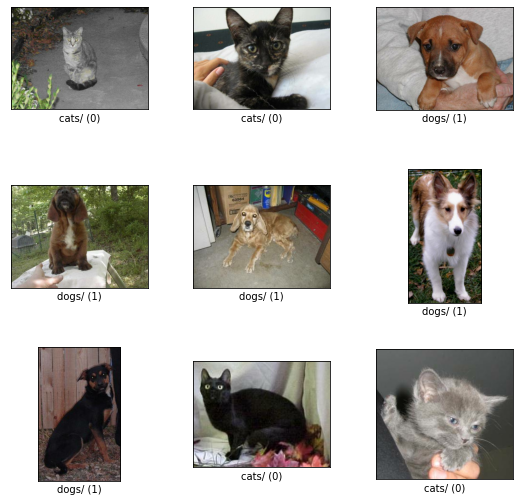

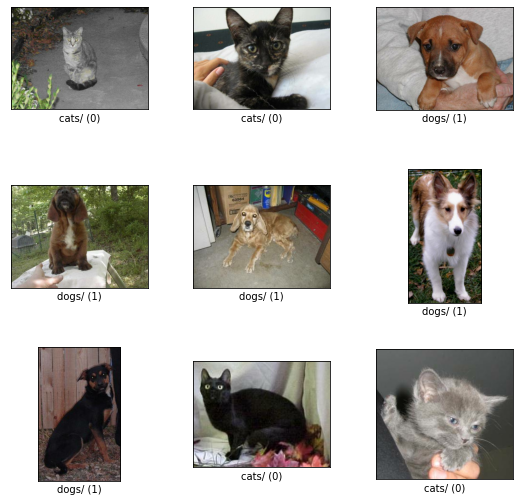

In [49]:
builder = tfds.ImageFolder('gs://kubeflow-test-288607-kubeflowpipelines-default/transfer-learning-keras-training/data/raw_data')
print(builder.info)  # num examples, labels... are automatically calculated
test, train = builder.as_dataset(split=['train/', 'test/'], shuffle_files=True)
tfds.show_examples(test, builder.info)

In [45]:
ds = ds.take(1)  # Only take a single example

for example in ds:  # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
  print(list(example.keys()))
  image = example["image"]
  label = example["label"]
  print(image.shape, label)


['image', 'label', 'image/filename']
(227, 299, 3) tf.Tensor(1, shape=(), dtype=int64)


In [44]:
ls

build_signature_example.py  predict_client.py  tfdv_example/
export.py*                  predict.py


In [54]:
# coding=utf-8
# Copyright 2020 The TensorFlow Datasets Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Image Classification Folder datasets."""

import collections
import os
import random
from typing import Dict, List, NoReturn, Optional, Tuple

import tensorflow.compat.v2 as tf
from tensorflow_datasets.core import dataset_builder
from tensorflow_datasets.core import dataset_info
from tensorflow_datasets.core import features as features_lib
from tensorflow_datasets.core import splits as split_lib
from tensorflow_datasets.core.utils import type_utils
from tensorflow_datasets.core.utils import version

_SUPPORTED_IMAGE_FORMAT = ('.jpg', '.jpeg', '.png')


_Example = collections.namedtuple('_Example', ['image_path', 'label'])

# Dict of 'split_name'-> `List[_Example]`
SplitExampleDict = Dict[str, List[_Example]]


class ImageFolder(dataset_builder.DatasetBuilder):
  """Generic image classification dataset created from manual directory.

  `ImageFolder` creates a `tf.data.Dataset` reading the original image files.

  The data directory should have the following structure:

  ```
  path/to/image_dir/
    split_name/  # Ex: 'train'
      label1/  # Ex: 'airplane' or '0015'
        xxx.png
        xxy.png
        xxz.png
      label2/
        xxx.png
        xxy.png
        xxz.png
    split_name/  # Ex: 'test'
      ...
  ```

  To use it:

  ```
  builder = tfds.ImageFolder('path/to/image_dir/')
  print(builder.info)  # num examples, labels... are automatically calculated
  ds = builder.as_dataset(split='train', shuffle_files=True)
  tfds.show_examples(ds, builder.info)
  ```

  """

  VERSION = version.Version('1.0.0')

  def __init__(
      self,
      root_dir: str,
      *,
      shape: Optional[type_utils.Shape] = None,
      dtype: Optional[tf.DType] = None,
  ):
    """Construct the `DatasetBuilder`.

    Args:
      root_dir: Path to the directory containing the images.
      shape: Image shape forwarded to `tfds.features.Image`.
      dtype: Image dtype forwarded to `tfds.features.Image`.
    """
    self._image_shape = shape
    self._image_dtype = dtype
    super(ImageFolder, self).__init__()
    self._data_dir = root_dir  # Set data_dir to the existing dir.

    # Extract the splits, examples, labels
    root_dir = os.path.expanduser(root_dir)
    self._split_examples, labels = _get_split_label_images(root_dir)

    # Update DatasetInfo labels
    self.info.features['label'].names = sorted(labels)

    # Update DatasetInfo splits
    split_dict = split_lib.SplitDict(self.name)
    for split_name, examples in self._split_examples.items():
      split_dict.add(split_lib.SplitInfo(
          name=split_name,
          shard_lengths=[len(examples)],
      ))
    self.info.update_splits_if_different(split_dict)

  def _info(self) -> dataset_info.DatasetInfo:
    return dataset_info.DatasetInfo(
        builder=self,
        description='Generic image classification dataset.',
        features=features_lib.FeaturesDict({
            'image': features_lib.Image(
                shape=self._image_shape,
                dtype=self._image_dtype,
            ),
            'label': features_lib.ClassLabel(),
            'image/filename': features_lib.Text(),
        }),
        supervised_keys=('image', 'label'),
    )

  def _download_and_prepare(self, **kwargs) -> NoReturn:
    raise NotImplementedError(
        'No need to call download_and_prepare function for {}.'.format(
            type(self).__name__))

  def download_and_prepare(self, **kwargs):  # -> NoReturn:
    return self._download_and_prepare()

  def _as_dataset(
      self,
      split,
      shuffle_files=False,
      decoders=None,
      read_config=None) -> tf.data.Dataset:
    """Generate dataset for given split."""
    del read_config  # Unused (automatically created in `DatasetBuilder`)
    if decoders:
      raise NotImplementedError(
          '`decoders` is not supported with {}'.format(type(self).__name__))
    if split not in self.info.splits.keys():
      raise ValueError(
          'Unrecognized split {}. Subsplit API not yet supported for {}. '
          'Split name should be one of {}.'.format(
              split, type(self).__name__, list(self.info.splits.keys())))

    # Extract all labels/images
    image_paths = []
    labels = []
    examples = self._split_examples[split]
    for example in examples:
      image_paths.append(example.image_path)
      labels.append(self.info.features['label'].str2int(example.label))

    # Build the tf.data.Dataset object
    ds = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    if shuffle_files:
      ds = ds.shuffle(len(examples))
    ds = ds.map(_load_example, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return ds


def _load_example(path: tf.Tensor, label: tf.Tensor) -> Dict[str, tf.Tensor]:
  img = tf.io.read_file(path)
  # Uses `channels` and `expand_animations` to make sure shape=(None, None, 3)
  img = tf.image.decode_image(img, channels=3, expand_animations=False)
  return (img, tf.cast(label, tf.int64))


def _get_split_label_images(
    root_dir: str,
) -> Tuple[SplitExampleDict, List[str]]:
  """Extract all label names and associated images.

  This function guarantee that examples are deterministically shuffled
  and labels are sorted.

  Args:
    root_dir: The folder where the `split/label/image.png` are located

  Returns:
    split_examples: Mapping split_names -> List[_Example]
    labels: The list off labels
  """
  split_examples = collections.defaultdict(list)
  labels = set()
  for split_name in sorted(_list_folders(root_dir)):
    split_dir = os.path.join(root_dir, split_name)
    for label_name in sorted(_list_folders(split_dir)):
      labels.add(label_name)
      split_examples[split_name].extend([
          _Example(image_path=image_path, label=label_name)
          for image_path
          in sorted(_list_img_paths(os.path.join(split_dir, label_name)))
      ])

  # Shuffle the images deterministically
  for split_name, examples in split_examples.items():
    rgn = random.Random(split_name)  # Uses different seed for each split
    rgn.shuffle(examples)
  return split_examples, sorted(labels)


def _list_folders(root_dir: str) -> List[str]:
  return [
      f for f in tf.io.gfile.listdir(root_dir)
      if tf.io.gfile.isdir(os.path.join(root_dir, f))
  ]


def _list_img_paths(root_dir: str) -> List[str]:
  return [
      os.path.join(root_dir, f)
      for f in tf.io.gfile.listdir(root_dir)
      if any(f.lower().endswith(ext) for ext in _SUPPORTED_IMAGE_FORMAT)
  ]


In [55]:
builder = ImageFolder("gs://kubeflow-test-288607-kubeflowpipelines-default/transfer-learning-keras-training/data/raw_data")

In [53]:
print(builder.info)

tfds.core.DatasetInfo(
    name='image_folder',
    version=1.0.0,
    description='Generic image classification dataset.',
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=308,
    splits={
        'test/': 84,
        'train/': 224,
    },
    supervised_keys=('image', 'label'),
    citation="""""",
    redistribution_info=,
)



tfds.core.DatasetInfo(
    name='image_folder',
    version=1.0.0,
    description='Generic image classification dataset.',
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=308,
    splits={
        'test/': 84,
        'train/': 224,
    },
    supervised_keys=('image', 'label'),
    citation="""""",
    redistribution_info=,
)



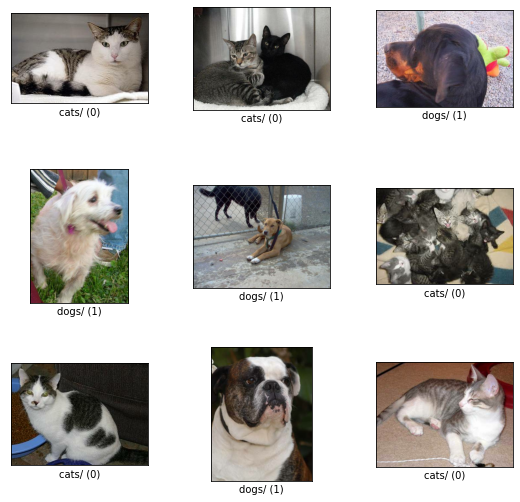

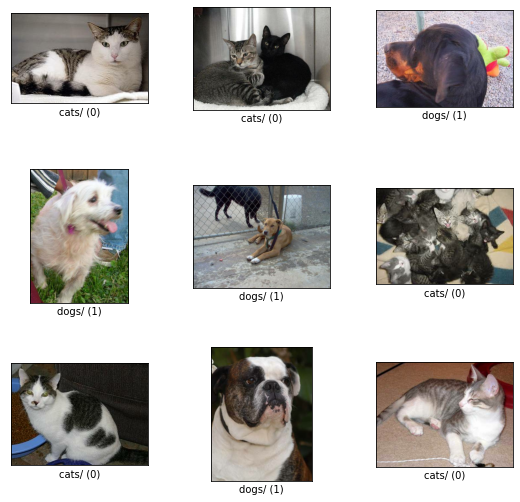

In [56]:
print(builder.info)  # num examples, labels... are automatically calculated
train_ds, test_ds = builder.as_dataset(split=['train/', 'test/'], shuffle_files=True)
tfds.show_examples(train_ds, builder.info)

In [57]:
train_ds.take(9)

<TakeDataset shapes: ((None, None, None), ()), types: (tf.uint8, tf.int64)>

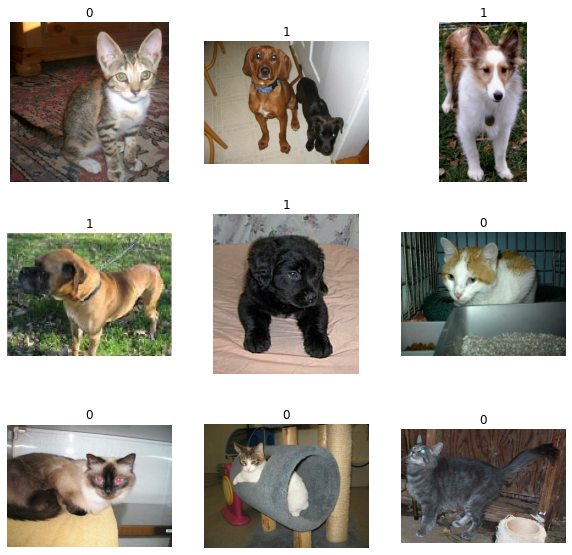

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")